# Analysis of total accessible market for automated utility-scale solar PV design

In [236]:
%%capture
!{sys.executable} -m pip install pandas tabulate matplotlib openpyxl
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

%matplotlib inline


In [237]:
# Get and process new capacity data
source = r'/Users/paul/Library/CloudStorage/OneDrive-SharedLibraries-7SecondSolar/The Company - Documents/01 Admin/1.1 Business Plan/Refund/Financial Model.xlsx'

new_capacity = pd.read_excel(source, sheet_name='new_capacity')
new_capacity = new_capacity.dropna()
utility = new_capacity["utility"].values[0]
distributed = new_capacity["distributed"].values[0]

In [238]:
# Get and process capacity growth data
annual_growth = pd.read_excel(source, sheet_name='annual_growth')
annual_growth = annual_growth.dropna()

annual_growth['Capacity'] = annual_growth['share'].apply(lambda x: x * (float(utility) + float(distributed)))
annual_growth.columns = ['Year', 'Share of growth', 'Capacity [GW]']
annual_growth['Share of growth'] = annual_growth['Share of growth'].apply(lambda x: f"{100 * x:.0f}%")
annual_growth['Capacity [GW]'] = annual_growth['Capacity [GW]'].apply(lambda x: f"{x:,.0f}")
total_capacity = annual_growth['Capacity [GW]'].str.replace(',', '').astype(float).sum()
annual_growth.loc[len(annual_growth.index)] = ['Total', '', f"{total_capacity:,.0f}"]

# Create growth table
md_html_table = annual_growth.to_html(index=False, escape=False)

# Apply CSS styles to center the table and highlight the total row
centered_html_table = f"""
<style>
    .table-container {{
        display: flex;
        justify-content: center;
        width: 100%;
    }}
    table {{
        width: 50%;
        text-align: center;
        border-collapse: collapse;
    }}
    th, td {{
        padding: 10px;
        border: 1px solid black;
        text-align: center;
    }}
    th {{
        background-color: #f2f2f2;
    }}
    tr:last-child {{
        font-weight: bold;
        background-color: #e0e0e0;
    }}
</style>
{md_html_table}
"""

In [239]:
# Get regional share of new_capacity
regional_capacity = pd.read_excel(source, sheet_name='world_share')
regional_capacity = regional_capacity.dropna()

regional_capacity.columns = ['Region', 'Share']
regional_capacity['Utility [GW]'] = regional_capacity['Share'].apply(
    lambda x: x * (float(utility)))
regional_capacity['Distributed [GW]'] = regional_capacity['Share'].apply(
    lambda x: x * (float(distributed)))
regional_capacity['Total Capacity [GW]'] = regional_capacity['Utility [GW]'] + regional_capacity['Distributed [GW]']

rest_of_world = regional_capacity[regional_capacity['Region'] == 'Rest of World']
regional_capacity = regional_capacity[regional_capacity['Region'] != 'Rest of World']
regional_capacity = regional_capacity.sort_values(by='Total Capacity [GW]', ascending=False)
regional_capacity = pd.concat([regional_capacity, rest_of_world])

total_capacity = regional_capacity['Total Capacity [GW]'].sum()
regional_capacity['Share'] = regional_capacity['Share'].apply(lambda x: f"{100 * x:.0f}%")

md_html_regional_table = regional_capacity.to_html(index=False, escape=False)
centered_html_regional_table = f"""
<style>
    .table-container {{
        display: flex;
        justify-content: center;
        width: 100%;
    }}
    table {{
        width: 50%;
        text-align: center;
        border-collapse: collapse;
    }}
    th, td {{
        padding: 10px;
        border: 1px solid black;
        text-align: left;
    }}
    th {{
        background-color: #f2f2f2;
    }}
    tr:last-child {{
        font-weight: bold;
        background-color: #e0e0e0;
    }}
</style>
{md_html_regional_table}
"""

In [240]:
# Get and process regional cost of engineering data
engineering_cost = pd.read_excel(source, sheet_name='engineering_cost')
engineering_cost = engineering_cost[['Region', 'Country', 'System design']]
engineering_cost.rename(columns={'System design': 'System design cost [US$/kW]'}, inplace=True)
region_avg = engineering_cost.groupby("Region", as_index=False)['System design cost [US$/kW]'].mean()
region_avg = region_avg.sort_values(by='System design cost [US$/kW]', ascending=False)

In [241]:
# Combining engineering cost and market size per region
regional_capacity = regional_capacity.merge(region_avg, on='Region', how='left')
weighted_average_cost_utility_cost = (
        regional_capacity['Utility [GW]'] * 1000_000 * regional_capacity['System design cost [US$/kW]']
).sum()


In [242]:
# Introduction
display(Markdown("""
## Introduction

The IEA estimates [[1](#ref1)] an additional {} GW of utility-scale and a further {} GW of distributed solar PV will be installed globally between 2024 and 2030. This paper discusses value of system design that can reasonably displaced by accurately automating the detail design of utility-scale solar PV.

""".format(f":{utility: ,.0f}", f"{distributed: ,.0f}")))


## Introduction

The IEA estimates [[1](#ref1)] an additional : 2,550 GW of utility-scale and a further  1,659 GW of distributed solar PV will be installed globally between 2024 and 2030. This paper discusses value of system design that can reasonably displaced by accurately automating the detail design of utility-scale solar PV.



In [243]:
assumptions = pd.read_excel(source, sheet_name='assumptions')
assumptions.columns = [heading.title() for heading in assumptions.columns]

assumption_names = {assumption: assumption.title() for assumption in assumptions['Assumption']}
assumptions['Assumption']= assumptions['Assumption'].apply(lambda x: assumption_names[x])

assumptions_display = assumptions.copy()
assumptions_display['Detail'] = assumptions_display['Detail'].apply(lambda x: f"{100*x:.0f}%")
assumptions_display['Concept'] = assumptions_display['Concept'].apply(lambda x: f"{100*x:.0f}%")


In [244]:
display(Markdown("""
## Approach and assumptions

AUTOPV automates the detailed engineering of utility-scale solar. Quantifying the total market of engineering value that could be displaced by automated design, we look at the International Energy Agency's (IEA) capacity increase forecasts for teh next five years [[1](#ref1)] and the Internation Renewable Energy Agency's (IRENA) report [[2](#ref2)] on the regional solar PV installation and development costs.

To find a reasonable answer we make several assumptions. Firstly we understand that there will be projects that are so complex that the will always require bespoke or traditional approaches. We are also mindful that it would likely not be possible to exclude the human engineer entirely from the process. Areas such as geotechnical investigations, earthing and lightning studies etc, are harder to automate reliably. Lastly, we beleive that at least som portion of the distributed or embedded solar PV will also be accessible for a product like AUTOPV.

Our assumptions around these issues are listed below:
{}
""".format(assumptions_display.to_html(index=False, escape=True))))


## Approach and assumptions

AUTOPV automates the detailed engineering of utility-scale solar. Quantifying the total market of engineering value that could be displaced by automated design, we look at the International Energy Agency's (IEA) capacity increase forecasts for teh next five years [[1](#ref1)] and the Internation Renewable Energy Agency's (IRENA) report [[2](#ref2)] on the regional solar PV installation and development costs.

To find a reasonable answer we make several assumptions. Firstly we understand that there will be projects that are so complex that the will always require bespoke or traditional approaches. We are also mindful that it would likely not be possible to exclude the human engineer entirely from the process. Areas such as geotechnical investigations, earthing and lightning studies etc, are harder to automate reliably. Lastly, we beleive that at least som portion of the distributed or embedded solar PV will also be accessible for a product like AUTOPV.

Our assumptions around these issues are listed below:
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Assumption</th>
      <th>Detail</th>
      <th>Concept</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Projects</td>
      <td>90%</td>
      <td>100%</td>
    </tr>
    <tr>
      <td>Design</td>
      <td>75%</td>
      <td>100%</td>
    </tr>
    <tr>
      <td>Distributed</td>
      <td>10%</td>
      <td>10%</td>
    </tr>
  </tbody>
</table>


In [245]:
# Breaking Down Solar PV Growth
display(Markdown("""
## Breaking down the solar PV growth
We use the _Cumulative renewable capacity in the accelerated case by country or region, 2030_, graph presented in the IEA report [[1](#ref1)] to apportion the capacity additions to the various regions."""))
display(Markdown(centered_html_regional_table))


## Breaking down the solar PV growth
We use the _Cumulative renewable capacity in the accelerated case by country or region, 2030_, graph presented in the IEA report [[1](#ref1)] to apportion the capacity additions to the various regions.


<style>
    .table-container {
        display: flex;
        justify-content: center;
        width: 100%;
    }
    table {
        width: 50%;
        text-align: center;
        border-collapse: collapse;
    }
    th, td {
        padding: 10px;
        border: 1px solid black;
        text-align: left;
    }
    th {
        background-color: #f2f2f2;
    }
    tr:last-child {
        font-weight: bold;
        background-color: #e0e0e0;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Region</th>
      <th>Share</th>
      <th>Utility [GW]</th>
      <th>Distributed [GW]</th>
      <th>Total Capacity [GW]</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>China</td>
      <td>48%</td>
      <td>1224.0</td>
      <td>796.32</td>
      <td>2020.32</td>
    </tr>
    <tr>
      <td>EU</td>
      <td>13%</td>
      <td>331.5</td>
      <td>215.67</td>
      <td>547.17</td>
    </tr>
    <tr>
      <td>US</td>
      <td>9%</td>
      <td>229.5</td>
      <td>149.31</td>
      <td>378.81</td>
    </tr>
    <tr>
      <td>India</td>
      <td>6%</td>
      <td>153.0</td>
      <td>99.54</td>
      <td>252.54</td>
    </tr>
    <tr>
      <td>MEA</td>
      <td>4%</td>
      <td>102.0</td>
      <td>66.36</td>
      <td>168.36</td>
    </tr>
    <tr>
      <td>Rest of World</td>
      <td>20%</td>
      <td>510.0</td>
      <td>331.80</td>
      <td>841.80</td>
    </tr>
  </tbody>
</table>


In [246]:
display(Markdown(""" \
It is clear that China is by far the most promising growth market for utility-scale solar PV, with the EU and US making up a combined 22% of the capacity growth in the next five years.\
"""))

 It is clear that China is by far the most promising growth market for utility-scale solar PV, with the EU and US making up a combined 22% of the capacity growth in the next five years.

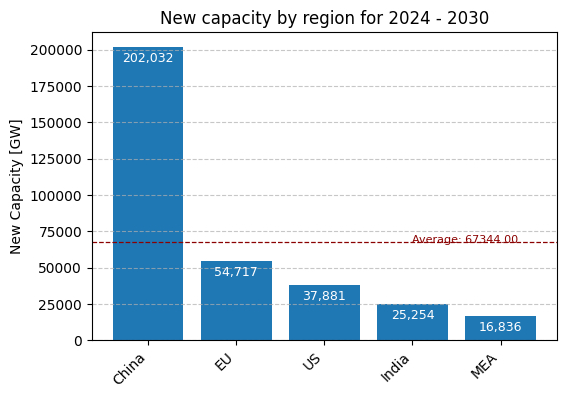

In [247]:
regional_plot = regional_capacity.copy()[:-1]
regional_plot['Total Capacity [GW]'] = regional_plot['Total Capacity [GW]'].apply(lambda x: f"{100 * x:.0f}")
regional_plot.loc[:, 'Total Capacity [GW]'] = pd.to_numeric(regional_plot['Total Capacity [GW]'].str.replace(",", ""))

plt.figure(figsize=(6, 4))
bars = plt.bar(regional_plot['Region'], regional_plot["Total Capacity [GW]"])
plt.ylabel("New Capacity [GW]")
plt.title("New capacity by region for 2024 - 2030")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

average_cost = regional_plot['Total Capacity [GW]'].mean()
plt.axhline(y=average_cost, color='darkred', linestyle='--', linewidth=0.9, label=f"Avg: {average_cost:.2f}")
plt.text(x=len(regional_plot["Region"]) - 0.8, y=average_cost - 100, s=f"Average: {average_cost:.2f}", color='darkred',
         fontsize=8, ha='right')

# Add data labels
min_height = 1000_000_000
for bar in bars:
    if (height := bar.get_height()) < min_height:
        min_height = height

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X position (centered on bar)
        height - min_height * 0.2,  # Y position (slightly below the top)
        f"{height:,.0f}",  # Format number with commas
        ha='center', va='top', fontsize=9, color="white"
    )

plt.show()

In [248]:
display(Markdown("""
In our analysis, we wish to gain an annual view of the growth between 2024 and 2030. This is not explicitly available from the IEA data, so we will assume an annual proportional growth as follows:
"""))

# Display the centered table
display(Markdown(centered_html_table))



In our analysis, we wish to gain an annual view of the growth between 2024 and 2030. This is not explicitly available from the IEA data, so we will assume an annual proportional growth as follows:



<style>
    .table-container {
        display: flex;
        justify-content: center;
        width: 100%;
    }
    table {
        width: 50%;
        text-align: center;
        border-collapse: collapse;
    }
    th, td {
        padding: 10px;
        border: 1px solid black;
        text-align: center;
    }
    th {
        background-color: #f2f2f2;
    }
    tr:last-child {
        font-weight: bold;
        background-color: #e0e0e0;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Year</th>
      <th>Share of growth</th>
      <th>Capacity [GW]</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>2025</td>
      <td>10%</td>
      <td>421</td>
    </tr>
    <tr>
      <td>2026</td>
      <td>15%</td>
      <td>631</td>
    </tr>
    <tr>
      <td>2027</td>
      <td>20%</td>
      <td>842</td>
    </tr>
    <tr>
      <td>2028</td>
      <td>25%</td>
      <td>1,052</td>
    </tr>
    <tr>
      <td>2029</td>
      <td>30%</td>
      <td>1,263</td>
    </tr>
    <tr>
      <td>Total</td>
      <td></td>
      <td>4,209</td>
    </tr>
  </tbody>
</table>


In [249]:
# The Cost of Engineering Design
display(Markdown("""
## The Cost of Engineering Design

The cost to design utility-scale solar PV varies significantly across regions. The following breakdown is from IRENA _Renewable power generation costs in 2023_ report [[2](#ref2)]. 
"""))


## The Cost of Engineering Design

The cost to design utility-scale solar PV varies significantly across regions. The following breakdown is from IRENA _Renewable power generation costs in 2023_ report [[2](#ref2)]. 


In [250]:
# Regional cost of engineering plot
plt.figure(figsize=(6, 4))
plt.bar(engineering_cost["Country"], engineering_cost["System design"])
plt.ylabel("System Engineer Cost [USD/kW]", fontsize=10)
plt.title("System Engineer Cost by Country")
plt.xticks(rotation=90, fontsize=6)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Average
average_cost = engineering_cost["System design"].mean()
plt.axhline(y=average_cost, color='darkred', linestyle='--', linewidth=0.9, label=f"Avg: {average_cost:.2f}")
plt.text(x=len(engineering_cost["Country"]) - 0.8, y=average_cost - 1.2, s=f"Average: {average_cost:.2f}",
         color='darkred', fontsize=8, ha='right')

# Quantiles
percentile_25 = engineering_cost["System design"].quantile(0.25)
percentile_75 = engineering_cost["System design"].quantile(0.75)

# Plot 25th percentile line
plt.axhline(y=percentile_25, color='blue', linestyle='--', linewidth=0.9, label=f"25th: {percentile_25:.2f}")
plt.text(x=len(engineering_cost["Country"]) - 0.5, y=percentile_25 + 0.5,
         s=f"25th: {percentile_25:.2f}", color='blue', fontsize=8, ha='right')

# Plot 75th percentile line
plt.axhline(y=percentile_75, color='blue', linestyle='--', linewidth=0.9, label=f"75th: {percentile_75:.2f}")
plt.text(x=len(engineering_cost["Country"]) - 0.5, y=percentile_75 + 0.5,
         s=f"75th: {percentile_75:.2f}", color='blue', fontsize=8, ha='right')

# Show the plot
plt.show()

KeyError: 'System design'

<Figure size 600x400 with 0 Axes>

In [ ]:
display(Markdown("""
The following figure shows these costs aggregated by region. 
"""))

In [ ]:
# Regional cost of engineering plot
plt.figure(figsize=(6, 4))
bars = plt.bar(region_avg["Region"], region_avg["System design"])
plt.ylabel("System Engineer Cost [USD/kW]")
plt.title("System Engineer Cost by Region")
plt.xticks(rotation=90, fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Average
plt.axhline(y=average_cost, color='darkred', linestyle='--', linewidth=0.9, label=f"Avg: {average_cost:.2f}")
plt.text(x=len(region_avg["Region"]) - 0.5, y=average_cost + 0.5, s=f"Average by country: {average_cost:.2f}",
         color='darkred', fontsize=8, ha='right')

# Add data labels
min_height = 1000_000_000
for bar in bars:
    if (height := bar.get_height()) < min_height:
        min_height = height

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X position (centered on bar)
        height - min_height * 0.2,  # Y position (slightly below the top)
        f"{height:,.2f}",  # Format number with commas
        ha='center', va='top', fontsize=9, color="white"
    )

# Show the plot
plt.show()

In [ ]:
display(Markdown("""
Considering the weighted cost per region to design solar PV, completing the design of {} GW of utility scale solar will cost approximately US${}B.
""".format(f"{regional_capacity['Utility [GW]'].sum()}", f"{weighted_average_cost_utility_cost/1000_000_000:,.1f}")))

## References

\[<a id="ref1">1</a>\] IEA (2024), Renewables 2024, IEA, Paris https://www.iea.org/reports/renewables-2024, Licence: CC BY 4.0

\[<a id="ref2">2</a>\] IRENA (2024), Renewable power generation costs in 2023, International Renewable Energy Agency, Abu Dhabi. https://www.irena.org/-/media/Files/IRENA/Agency/Publication/2024/Sep/IRENA_Renewable_power_generation_costs_in_2023.pdf